In [1]:
#must be very first statement

import tensorflow as tf
tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Num GPUs Available:  1
Default GPU Device: /device:GPU:0


In [2]:
#%config IPCompleter.greedy=True

In [3]:
#utils'

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.datasets import mnist
import PIL


def getDigits(show=False):
    (x_train, t_train), (x_test, t_test) = mnist.load_data()

    #print(x_train.shape)

    if show:
        showImages(x_train, t_train,5)

    return x_train,t_train,x_test, t_test


#### CALLBACKS (https://github.com/davidADSP/GDL_code/blob/master/utils/callbacks.py)
class CustomCallback(Callback):

    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_batch_end(self, batch, logs={}):
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size=(1, self.vae.z_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

            filepath = os.path.join(self.run_folder, 'images',
                                    'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1

#### CALLBACKS (https://github.com/davidADSP/GDL_code/blob/master/utils/callbacks.py)
def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''

    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch / step_size))

        return new_lr

    return LearningRateScheduler(schedule)

Using TensorFlow backend.


In [4]:
#data prep

from keras.datasets import cifar10
cifar10.load_data()

my_labels = [2]
all_label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_names = []
for label_index in my_labels:
    label_names.append(all_label_names[label_index])  

print("Defining new Labeling:")
print(dict(zip(range(len(my_labels)),label_names)))

#if my_labels = [5,6,8] then 5 returns 0, 6 returns 1, 8 returns 2, ...
def convert_label(label):
    return dict(zip(my_labels,range(len(my_labels))))[label]

def label_name(num):
    return label_names[num]

# The data, split between train and test sets:
(x_train_all, y_train_all), (x_test_all, y_test_all) = cifar10.load_data()
    
#temp lists
x_train = []
y_train_numerical = []

#filter training data for my_labels
for i in range(len(x_train_all)):
    if y_train_all[i] in my_labels:
        x_train.append(x_train_all[i])
        y_train_numerical.append(convert_label(y_train_all[i][0]))
    else:
        pass

x_train = np.array(x_train)
y_train_numerical = np.array(y_train_numerical)

print("Training Data:\n")
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'samples,', y_train_numerical.shape[0], 'labels')
print("\nClass  |  Counts:")
(unique, counts) = np.unique(y_train_numerical, return_counts=True)
for i, label in enumerate(unique):
    print(label_name(label),"\t", counts[i])


x_test = []
y_test_numerical = []

#filter test data
for i in range(len(x_test_all)):
    if y_test_all[i] in my_labels:
        x_test.append(x_test_all[i])
        y_test_numerical.append(convert_label(y_test_all[i][0]))
    else:
        pass

x_test = np.array(x_test)
y_test_numerical = np.array(y_test_numerical)

print("\n\nTesting Data:\n")
print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'samples,', y_test_numerical.shape[0], 'labels')
print("\nClass  |  Counts:")
(unique, counts) = np.unique(y_test_numerical, return_counts=True)
for i, label in enumerate(unique):
    print(label_name(label),"\t", counts[i])
    
x_train=x_train.reshape(x_train.shape[0],32,32,3)
x_test=x_test.reshape(x_test.shape[0],32,32,3)

x_train = x_train.astype('float32')[:1000]
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


Defining new Labeling:
{0: 'bird'}
Training Data:

x_train shape: (5000, 32, 32, 3)
5000 samples, 5000 labels

Class  |  Counts:
bird 	 5000


Testing Data:

x_test shape: (1000, 32, 32, 3)
1000 samples, 1000 labels

Class  |  Counts:
bird 	 1000


In [5]:
#model class

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras import callbacks

import numpy as np
import json
import os
import pickle


class VariationalAutoencoder():
    def __init__(self
                 , input_dim
                 , encoder_conv_filters
                 , encoder_conv_kernel_size
                 , encoder_conv_strides
                 , decoder_conv_t_filters
                 , decoder_conv_t_kernel_size
                 , decoder_conv_t_strides
                 , z_dim
                 , use_batch_norm=False
                 , use_dropout=False
                 ):

        self.name = 'variational_autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):

        ### THE ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters=self.encoder_conv_filters[i]
                , kernel_size=self.encoder_conv_kernel_size[i]
                , strides=self.encoder_conv_strides[i]
                , padding='same'
                , name='encoder_conv_' + str(i)
            )

            x = conv_layer(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            x = LeakyReLU()(x)

            if self.use_dropout:
                x = Dropout(rate=0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]
#-----------------------------
        print("shape_bef_flat",shape_before_flattening)
        x = Flatten()(x)
        print("shape_aft_flat",x)
        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))

        def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1)
            return mu + K.exp(log_var / 2) * epsilon #try without /2
    
        encoder_output = Lambda(sampling, name='encoder_output')([self.mu, self.log_var])
        print("encoder_output: ",encoder_output)
        self.encoder = Model(encoder_input, encoder_output)

        ### THE DECODER

        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
        print("dec_input",decoder_input)
        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters=self.decoder_conv_t_filters[i]
                , kernel_size=self.decoder_conv_t_kernel_size[i]
                , strides=self.decoder_conv_t_strides[i]
                , padding='same'
                , name='decoder_conv_t_' + str(i)
            )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:
                    x = Dropout(rate=0.25)(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x
        print("dec_inputtii",decoder_input)
        self.decoder = Model(decoder_input, decoder_output)

        ### THE FULL VAE
        model_input = encoder_input
        model_output = self.decoder(encoder_output)
        
        self.model = Model(model_input, model_output)

    def compile(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate

        ### COMPILATION
        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])
            return r_loss * r_loss_factor

        def vae_kl_loss(y_true, y_pred):
            kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis=1)
            return kl_loss

        def vae_loss(y_true, y_pred):

            #return 0.99*vae_r_loss(y_true,y_pred)+0.01*vae_kl_loss(y_true,y_pred)
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return r_loss + kl_loss

        optimizer = Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer, loss=vae_loss, metrics=[vae_r_loss, vae_kl_loss])

    def save(self, folder="run"):
        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pickle.dump([
                self.input_dim
                , self.encoder_conv_filters
                , self.encoder_conv_kernel_size
                , self.encoder_conv_strides
                , self.decoder_conv_t_filters
                , self.decoder_conv_t_kernel_size
                , self.decoder_conv_t_strides
                , self.z_dim
                , self.use_batch_norm
                , self.use_dropout
            ], f)

        self.plot_model(folder)

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches=100, initial_epoch=0, lr_decay=1):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        checkpoint_filepath = os.path.join(run_folder, "weights/weights.h5")
        
        model_checkpoint_callback = callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_acc',
            mode='max')

        
        #checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only=True, verbose=1)
        #checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only=True, verbose=1)

        callbacks_list = [custom_callback, lr_sched, model_checkpoint_callback]

        self.model.fit(
            x_train
            , x_train
            , batch_size=batch_size
            , shuffle=True
            , epochs=epochs
            , initial_epoch=initial_epoch
            , callbacks=callbacks_list
        )

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder, 'viz/model.png'), show_shapes=True,
                   show_layer_names=True)
        plot_model(self.encoder, to_file=os.path.join(run_folder, 'viz/encoder.png'), show_shapes=True,
                   show_layer_names=True)
        plot_model(self.decoder, to_file=os.path.join(run_folder, 'viz/decoder.png'), show_shapes=True,
                   show_layer_names=True)



In [6]:
#training
SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run'

cwd = os.getcwd()
print(cwd)
if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #




S:\Hub\ML_SS_2020


In [ ]:

vae = VariationalAutoencoder(
    input_dim = (32,32,3)
    , encoder_conv_filters = [128,128,128,512]
    , encoder_conv_kernel_size = [2,2,3,4]
    , encoder_conv_strides = [1,1,2,2]
    , decoder_conv_t_filters = [512,128,128,3]
    , decoder_conv_t_kernel_size = [4,3,2,2]
    , decoder_conv_t_strides = [2,2,1,1]
    , z_dim = 128
)
vae.save(RUN_FOLDER)

vae.load_weights("run/weights/weights.h5")

vae.encoder.summary()

LEARNING_RATE = 0.001
R_LOSS_FACTOR = 1000
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

BATCH_SIZE = 32
EPOCHS = 1000
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

vae.train(
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)
vae.save()


In [8]:
LEARNING_RATE = 0.00075
R_LOSS_FACTOR = 1000
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

BATCH_SIZE = 32
EPOCHS = 1000
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

vae.train(
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)
vae.save()

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 1/1000
Executing op __inference_keras_scratch_graph_256224 in device /job:localhost/replica:0/task:0/device:GPU:0
1000/1000 [==============================] - 10s 10ms/step - loss: 22.9052 - vae_r_loss: 12.8706 - vae_kl_loss: 10.0347
Epoch 2/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 20.2420 - vae_r_loss: 10.3650 - vae_kl_loss: 9.8770
Epoch 3/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 20.0193 - vae_r_loss: 10.1976 - vae_kl_loss: 9.8217
Epoch 4/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 20.1019 - vae_r_loss: 10.2670 - vae_kl_loss: 9.8349
Epoch 5/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 20.1155 - vae_r_loss: 10.3163 - vae_kl_loss: 9.7992
Epoch 6/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 20.1279 - vae_r_loss: 10.2025 - vae_kl_loss: 9.9254
Epoch 7/1000
1000/1000 [

1000/1000 [==============================] - 2s 2ms/step - loss: 19.9933 - vae_r_loss: 10.0314 - vae_kl_loss: 9.9619
Epoch 122/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 19.8449 - vae_r_loss: 9.8305 - vae_kl_loss: 10.0144: 0s - loss: 19.9383 - vae_r_loss: 9.8460 - 
Epoch 123/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 19.7438 - vae_r_loss: 9.8116 - vae_kl_loss: 9.9322
Epoch 124/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 19.7634 - vae_r_loss: 9.6747 - vae_kl_loss: 10.0887
Epoch 125/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 20.0526 - vae_r_loss: 10.0711 - vae_kl_loss: 9.9814
Epoch 126/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 19.8735 - vae_r_loss: 9.7704 - vae_kl_loss: 10.1031
Epoch 127/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 19.6878 - vae_r_loss: 9.7322 - vae_kl_loss: 9.9556
Epoch 128/1000
1000/1000 [=======================

1000/1000 [==============================] - 5s 5ms/step - loss: 19.5042 - vae_r_loss: 9.5272 - vae_kl_loss: 9.9770
Epoch 243/1000
1000/1000 [==============================] - 5s 5ms/step - loss: 19.6275 - vae_r_loss: 9.6159 - vae_kl_loss: 10.0116
Epoch 244/1000
1000/1000 [==============================] - 5s 5ms/step - loss: 19.3341 - vae_r_loss: 9.4217 - vae_kl_loss: 9.9125
Epoch 245/1000
1000/1000 [==============================] - 5s 5ms/step - loss: 19.3972 - vae_r_loss: 9.3295 - vae_kl_loss: 10.0677: 3s - loss: 19.1
Epoch 246/1000
1000/1000 [==============================] - 6s 6ms/step - loss: 19.4376 - vae_r_loss: 9.3672 - vae_kl_loss: 10.0704
Epoch 247/1000
1000/1000 [==============================] - 8s 8ms/step - loss: 19.5251 - vae_r_loss: 9.4119 - vae_kl_loss: 10.1133
Epoch 248/1000
1000/1000 [==============================] - 8s 8ms/step - loss: 19.5013 - vae_r_loss: 9.4061 - vae_kl_loss: 10.0952
Epoch 249/1000
1000/1000 [==============================] - 7s 7ms/step - lo

KeyboardInterrupt: 

In [7]:
#Higher Z Dim and Lower R Loss Factor

vae = VariationalAutoencoder(
    input_dim = (32,32,3)
    , encoder_conv_filters = [128,128,128,512]
    , encoder_conv_kernel_size = [2,2,3,4]
    , encoder_conv_strides = [1,1,2,2]
    , decoder_conv_t_filters = [512,128,128,3]
    , decoder_conv_t_kernel_size = [4,3,2,2]
    , decoder_conv_t_strides = [2,2,1,1]
    , z_dim = 400
)
vae.save(RUN_FOLDER)

LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 250
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

BATCH_SIZE = 32
EPOCHS = 250
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

vae.train(
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)
vae.save()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/t

C:\Users\Admin\Anaconda3\envs\ml20\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.442000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1000/1000 [==============================] - 11s 11ms/step - loss: 13.8191 - vae_r_loss: 13.6566 - vae_kl_loss: 0.1625
Epoch 2/250
1000/1000 [==============================] - 2s 2ms/step - loss: 12.6527 - vae_r_loss: 11.7592 - vae_kl_loss: 0.8935
Epoch 3/250
1000/1000 [==============================] - 2s 2ms/step - loss: 11.6451 - vae_r_loss: 10.2850 - vae_kl_loss: 1.3601
Epoch 4/250
1000/1000 [==============================] - 2s 2ms/step - loss: 11.7820 - vae_r_loss: 10.3711 - vae_kl_loss: 1.4110
Epoch 5/250
1000/1000 [==============================] - 3s 3ms/step - loss: 11.9178 - vae_r_loss: 10.5241 - vae_kl_loss: 1.3937
Epoch 6/250
1000/1000 [==============================] - 3s 3ms/step - loss: 11.4085 - vae_r_loss: 10.0032 - vae_kl_loss: 1.4053
Epoch 7/250
1000/1000 [==============================] - 3s 3ms/step - loss: 11.1361 - vae_r_loss: 9.6928 - vae_kl_loss: 1.4433
Epoch 8/250
1000/1000 [==============================] - 2s 2ms/step - loss: 11.3421 - vae_r_loss: 9.9195 - 

1000/1000 [==============================] - 12s 12ms/step - loss: 10.9425 - vae_r_loss: 9.5118 - vae_kl_loss: 1.4307
Epoch 64/250
1000/1000 [==============================] - 11s 11ms/step - loss: 10.8629 - vae_r_loss: 9.4317 - vae_kl_loss: 1.4312
Epoch 65/250
1000/1000 [==============================] - 16s 16ms/step - loss: 11.0335 - vae_r_loss: 9.5802 - vae_kl_loss: 1.4533
Epoch 66/250
1000/1000 [==============================] - 19s 19ms/step - loss: 11.1512 - vae_r_loss: 9.6411 - vae_kl_loss: 1.5101
Epoch 67/250
1000/1000 [==============================] - 16s 16ms/step - loss: 11.2470 - vae_r_loss: 9.7899 - vae_kl_loss: 1.4571
Epoch 68/250
1000/1000 [==============================] - 15s 15ms/step - loss: 11.1746 - vae_r_loss: 9.6899 - vae_kl_loss: 1.4847
Epoch 69/250
1000/1000 [==============================] - 7s 7ms/step - loss: 11.0463 - vae_r_loss: 9.6304 - vae_kl_loss: 1.4160
Epoch 70/250
1000/1000 [==============================] - 10s 10ms/step - loss: 11.1331 - vae_r_lo

InternalError: GPU sync failed

In [10]:
LEARNING_RATE = 0.0000005
R_LOSS_FACTOR = 1000
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

BATCH_SIZE = 32
EPOCHS = 250
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

vae.train(
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)
vae.save()

Epoch 1/250
Executing op __inference_keras_scratch_graph_2269545 in device /job:localhost/replica:0/task:0/device:GPU:0
5000/5000 [==============================] - 13s 3ms/step - loss: 22.7694 - vae_r_loss: 13.4576 - vae_kl_loss: 9.3118
Epoch 2/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7356 - vae_r_loss: 13.4230 - vae_kl_loss: 9.3126
Epoch 3/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6703 - vae_r_loss: 13.3638 - vae_kl_loss: 9.3065
Epoch 4/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7083 - vae_r_loss: 13.4114 - vae_kl_loss: 9.2969
Epoch 5/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7976 - vae_r_loss: 13.4947 - vae_kl_loss: 9.3028
Epoch 6/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7647 - vae_r_loss: 13.4429 - vae_kl_loss: 9.3219: 1s - loss:
Epoch 7/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7357 - vae_r_loss: 13.422

5000/5000 [==============================] - 8s 2ms/step - loss: 22.7481 - vae_r_loss: 13.4249 - vae_kl_loss: 9.3232
Epoch 125/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6800 - vae_r_loss: 13.3653 - vae_kl_loss: 9.3147
Epoch 126/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6786 - vae_r_loss: 13.3845 - vae_kl_loss: 9.2941
Epoch 127/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6855 - vae_r_loss: 13.3912 - vae_kl_loss: 9.2943
Epoch 128/250
5000/5000 [==============================] - ETA: 0s - loss: 22.7621 - vae_r_loss: 13.4595 - vae_kl_loss: 9.30 - 8s 2ms/step - loss: 22.7670 - vae_r_loss: 13.4681 - vae_kl_loss: 9.2989
Epoch 129/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6929 - vae_r_loss: 13.3859 - vae_kl_loss: 9.3069
Epoch 130/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7545 - vae_r_loss: 13.4401 - vae_kl_loss: 9.3145
Epoch 131/250
5000/5000 [====

5000/5000 [==============================] - 8s 2ms/step - loss: 22.7055 - vae_r_loss: 13.3879 - vae_kl_loss: 9.3176
Epoch 249/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6578 - vae_r_loss: 13.3640 - vae_kl_loss: 9.2937
Epoch 250/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7227 - vae_r_loss: 13.4174 - vae_kl_loss: 9.3053


## Further Testing:

In [ ]:
#test again


vae = VariationalAutoencoder(
    input_dim = (32,32,3)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

#vae.load_weights("C:\\Users\\adoerr\\Desktop\\Machine Learning\\Aufgabe 2\\run\\weights\\weights-033-34.17.h5")


AxesImage(54,36;334.8x217.44)


NameError: name 'vae' is not defined

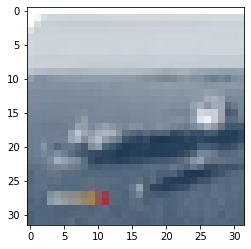

In [13]:
testindex = 4999
img = x_train[testindex]
#print("Correct label =",label_name(y_test_numerical[testindex]))
print(plt.imshow(img))
img = img.reshape((1,) + img.shape)

encoding = vae.encoder.predict(img)
reconst = vae.decoder.predict(encoding)[0].squeeze()

print(encoding)

#filepath = os.path.join(self.run_folder, 'images','img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
#print("Prediction:",vae.encoder.predict(img))
#print("Prediction:",vae.decoder.predict(vae.encoder.predict(img)))
#print(vae.decoder.predict(vae.encoder.predict(img)).type
#print(vae.encoder.predict)
#plt.imshow(vae.decoder.predict(vae.encoder.predict(img)))

In [ ]:
print(plt.imshow(reconst))

In [ ]:
import matplotlib.pyplot as plt
testindex = 51
img = x_test[testindex]
plt.imshow(img)
print(label_name(y_test_numerical[testindex]))